In [147]:
import os
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from skimage import io, transform
from tqdm.auto import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import random
from math import *
import imutils

import xml.etree.ElementTree as ET

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torchsummary import summary
import torchvision.transforms.functional as TF
from __future__ import print_function, division
import pandas as pd
import time
import copy
plt.ion()

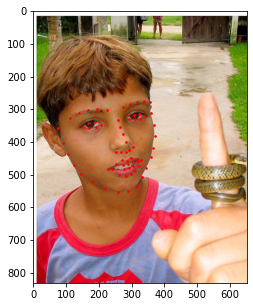

In [148]:
''' Visualise sample images '''
file=open('D:/Dev Projects/DeepStack/face-landmark/ibug_300W_large_face_landmark_dataset/helen/trainset/2908549_1.pts','r')
lines=file.readlines()[3:-1]

landmarks=[]

for lines in lines:
    x,y=lines.split(' ')
    landmarks.append([floor(float(x)),floor(float(y[:-1]))])

landmarks=np.array(landmarks)

plt.figure(figsize=(5,5))
plt.imshow(io.imread('D:/Dev Projects/DeepStack/face-landmark/ibug_300W_large_face_landmark_dataset/helen/trainset/2908549_1.jpg'))
plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')

plt.show()



In [149]:
class Transforms():
    def __init__(self):
        pass
    
    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)
        
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [150]:
class FaceLandmarkDataset(Dataset):
    def __init__(self, transform=None):
        tree=ET.parse('D:/Dev Projects/DeepStack/face-landmark/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
        root=tree.getroot()

        self.image_filenames=[]
        self.landmarks=[]
        self.crops=[]
        self.transform=transform
        self.root_dir='D:/Dev Projects/DeepStack/face-landmark/ibug_300W_large_face_landmark_dataset'

        for filename in root[2]:
            self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))
            self.crops.append(filename[0].attrib)

            landmark=[]

            for num in range(68):
                x_coord=int(filename[0][num].attrib['x'])
                y_coord=int(filename[0][num].attrib['y'])

                landmark.append([x_coord, y_coord])
            self.landmarks.append(landmark)

        self.landmarks=np.array(self.landmarks).astype('float32')

        assert len(self.image_filenames)==len(self.landmarks)
    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image=cv2.imread(self.image_filenames[idx],0)
        landmarks=self.landmarks[idx]

        if self.transform:
            image, landmarks=self.transform(image, landmarks, self.crops[idx])

        landmarks=landmarks - 0.5
        return image, landmarks

In [151]:
img_dataset=FaceLandmarkDataset(Transforms())

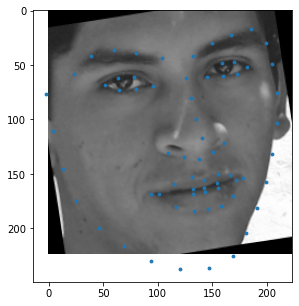

In [152]:
''' Visualising train set transform'''
image, landmarks = img_dataset[15]
landmarks = (landmarks + 0.5) * 224
plt.figure(figsize=(5, 5))
plt.imshow(image.numpy().squeeze(), cmap='gray');
plt.scatter(landmarks[:,0], landmarks[:,1], s=8);

In [153]:

'''splitting dataset into train and test '''

len_test=int(0.1*len(img_dataset))
len_train=len(img_dataset)-len_test

print('length of train set:',len_train)
print('length of test set:',len_test)

train, test=torch.utils.data.random_split(img_dataset, [len_train, len_test])


#shufffle batch

train_loader=DataLoader(train, batch_size=4, shuffle=True)
test_loader=DataLoader(test, batch_size=4, shuffle=True)

length of train set: 6000
length of test set: 666


In [154]:
images, landmarks=next(iter(train_loader))
print(images.shape, landmarks.shape)

torch.Size([4, 1, 224, 224]) torch.Size([4, 68, 2])


In [155]:
''' Creating the Xception Net Model'''

''' Depthwise Separable Convolution'''

class DepthewiseSeperableConv2d(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, **kwargs):
        super(DepthewiseSeperableConv2d, self).__init__()

        self.depthwise = nn.Conv2d(input_channels, input_channels, kernel_size, groups = input_channels, bias = False, **kwargs)
        self.pointwise = nn.Conv2d(input_channels, output_channels, 1, bias = False)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)

        return x



''' Entry block'''


class EntryBlock(nn.Module):
    def __init__(self):
        super(EntryBlock, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding = 1, bias = False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding = 1, bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )

        self.conv3_residual = nn.Sequential(
            DepthewiseSeperableConv2d(64, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(64, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(3, stride = 2, padding = 1),
        )

        self.conv3_direct = nn.Sequential(
            nn.Conv2d(64, 128, 1, stride = 2),
            nn.BatchNorm2d(128),
        )

        self.conv4_residual = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(128, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(128, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(3, stride = 2, padding = 1)
        )

        self.conv4_direct = nn.Sequential(
            nn.Conv2d(128, 256, 1, stride = 2),
            nn.BatchNorm2d(256),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        residual = self.conv3_residual(x)
        direct = self.conv3_direct(x)
        x = residual + direct
        
        residual = self.conv4_residual(x)
        direct = self.conv4_direct(x)
        x = residual + direct

        return x

''' Middle basic Block'''
class MiddleBasicBlock(nn.Module):
    def __init__(self):
        super(MiddleBasicBlock, self).__init__()

        self.conv1 = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256)
        )
        self.conv2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256)
        )
        self.conv3 = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256)
        )

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.conv2(residual)
        residual = self.conv3(residual)

        return x + residual


class MiddleBlock(nn.Module):
    def __init__(self, num_blocks):
        super().__init__()

        self.block = nn.Sequential(*[MiddleBasicBlock() for _ in range(num_blocks)])

    def forward(self, x):
        x = self.block(x)

        return x

''' Exit Block'''

class ExitBlock(nn.Module):
    def __init__(self):
        super(ExitBlock, self).__init__()

        self.residual = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(3, stride = 2, padding = 1)
        )

        self.direct = nn.Sequential(
            nn.Conv2d(256, 512, 1, stride = 2),
            nn.BatchNorm2d(512)
        )

        self.conv = nn.Sequential(
            DepthewiseSeperableConv2d(512, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(512, 1024, 3, padding = 1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2)
        )

        self.dropout = nn.Dropout(0.3)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        direct = self.direct(x)
        residual = self.residual(x)
        x = direct + residual
        
        x = self.conv(x)
        x = self.avgpool(x)
        x = self.dropout(x)

        return x

''' Xception Model Final'''
class XceptionNet(nn.Module):
    def __init__(self, num_middle_blocks = 6):
        super(XceptionNet, self).__init__()

        self.entry_block = EntryBlock()
        self.middel_block = MiddleBlock(num_middle_blocks)
        self.exit_block = ExitBlock()

        self.fc = nn.Linear(1024, 136)

    def forward(self, x):
        x = self.entry_block(x)
        x = self.middel_block(x)
        x = self.exit_block(x)

        x = x.view(x.size(0), -1)
        
        x = self.fc(x)

        return x


    



        

        





In [156]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Test Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

In [ ]:
''' Training loop'''


''' Loggin training metrics to tensorboard'''
import torch.utils.tensorboard as tensorboard
writer=tensorboard.SummaryWriter()


torch.autograd.set_detect_anomaly(True)
model=XceptionNet()

criterion=nn.MSELoss()
optimiser=optim.Adam(model.parameters(),lr=0.001)
loss_min=np.inf
num_epochs=10
start_time=time.time()

for epoch in range(1, num_epochs+1):
    loss_train=0
    loss_val=0
    run_loss=0

    model.train()
    for step in range(1, len(train_loader)+1):
        images,landmarks=next(iter(train_loader))
        images=images.cpu()
        landmarks=landmarks.view(landmarks.size(0),-1).cpu()

        pred=model(images)

        optimiser.zero_grad()
        
        loss_train_step=criterion(pred, landmarks)

        loss_train_step.backward()
        optimiser.step()

        loss_train+=loss_train_step.item()
        run_loss+=loss_train/step

        print_overwrite(step,len(train_loader), run_loss,'train')

    model.eval()
    with torch.no_grad():
        for step in range(1, len(test_loader+1)):
            images, landmarks=next(iter(test_loader))
            images=images.cpu()
            landmarks=landmarks.view(landmarks.size(0),-1).cpu()

            pred=model(images)
            loss_test_step=criterion(pred, landmarks)

            loss_test=loss_test_step.item()
            run_loss=loss_test/step

            print_overwrite(step,len(test_loader), run_loss,'test')

    loss_train=loss_train/len(train_loader)
    loss_test=loss_test/len(test_loader)
    writer.add_scalar(loss_train, 'loss_train')
    writer.add_scalar(loss_test, 'loss_test')


    print("/n---------------------------------------")

    print("Epoch: {}, Train Loss: {:.4f}, Test Loss: {:.4f}".format(epoch, loss_train, loss_test))

    if loss_test<loss_min:
        loss_min=loss_test
        torch.save(model.state_dict(), './model_best.pth')
        print("Minimum test loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))

        print("Model saving...")

print("Training complete")



    
writer.flush()

